In [56]:
import numpy as np
import matplotlib.pyplot as plt
import math
import glob as glob
import statsmodels.api as sm
import pandas as pd
from sklearn import linear_model
from sklearn import metrics
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
import itertools
from sklearn.metrics import mean_squared_error
from scipy.spatial import ConvexHull
import seaborn as sns

class ShapeSence:
    def loadData(self):
        # rawdata/下からcsvデータを読み込む
        files =  glob.glob('cleanData/ShapeSenceAverage.csv')
        width = pd.DataFrame()
        height = pd.DataFrame()
        gx = pd.DataFrame()
        gy = pd.DataFrame()
        for f in files:
            df = pd.read_csv(f, header=0)
            wdf = df[["p1","p2","p3","width"]]
            hdf = df[["p1","p2","p3","height"]]
            gydf = df[["p1","p2","p3","Gy"]]
            width = pd.concat([width,wdf])
            height = pd.concat([height,hdf])
            gy = pd.concat([gy,gydf])
        self.Y_width = width["width"]
        self.Y_height = height["height"]
        self.Y_gy = gy["Gy"]
        self.X_width = width.drop("width",axis=1)
        self.X_height = height.drop("height",axis=1)
        self.X_gy = gy.drop("Gy",axis=1)
    
    # n:回帰の次元
    def regression(self,n):
        # 回帰に用いる変数設定 https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
        poly = PolynomialFeatures(degree=n) #n次回帰
        self.dim = n
        width = poly.fit_transform(self.X_width) #widthに対応するw,h,gx,gyのn次交差？を取得
        height = poly.fit_transform(self.X_height)
        gy = poly.fit_transform(self.X_gy)

        # width, heightが定数項を含んでいるので fit_intercept = False でOK
        model_width = linear_model.LinearRegression(fit_intercept=False)
        model_height = linear_model.LinearRegression(fit_intercept=False)
        model_gy = linear_model.LinearRegression(fit_intercept=False)
        
        model_width.fit(width,self.Y_width)
        model_height.fit(height,self.Y_height)
        model_gy.fit(gy,self.Y_gy)

        self.width_coef = model_width.coef_
        self.height_coef = model_height.coef_
        self.gy_coef = model_gy.coef_
        
        self.R2_width = model_width.score(width,self.Y_width)
        self.R2_height = model_width.score(height,self.Y_height)
        self.R2_gy = model_width.score(gy,self.Y_gy)
        
    def printError(self):
        predictWidth = []
        predictHeight = []
        predictGy = []
        for i ,row in self.X_width.iterrows():
            predictWidth.append(self.predictWidth([row[0],row[1],row[2]]))
        print('MSE width : %.3f' % mean_squared_error(self.Y_width,predictWidth))
        print('R^2 width : %.3f' % self.R2_width)

        for i ,row in self.X_height.iterrows():
            predictHeight.append(self.predictHeight([row[0],row[1],row[2]]))
        print('MSE height : %.3f' % mean_squared_error(self.Y_height,predictHeight))
        print('R^2 height : %.3f' % self.R2_height)
        
        for i ,row in self.X_gy.iterrows():
            predictGy.append(self.predictGy([row[0],row[1],row[2]]))
        print('MSE gy : %.3f' % mean_squared_error(self.Y_gy,predictGy))
        print('R^2 gy : %.3f' % self.R2_gy)
#         print('R^2 width : %.3f' % (mod.score(X_train, y_train), mod.score(X_test, y_test)))

    
    # shape:目標形状[width,height,Gy](*cm)
    def optimize(self,shape):
        self.shape = [shape[0]/10,shape[1]/10,shape[2]/10]
        cons = ({"type":"ineq","fun":lambda x : x[0]},
        {"type":"ineq","fun":lambda x : 180 - x[0]},
        {"type":"ineq","fun":lambda x : x[1]},
        {"type":"ineq","fun":lambda x : x[0] - x[1]},
        {"type":"ineq","fun":lambda x : 90 - (x[0] - x[1])},
        {"type":"ineq","fun":lambda x : x[2]},
        {"type":"ineq","fun":lambda x : x[1] - x[2]},
        {"type":"ineq","fun":lambda x : 90 - (x[1] - x[2])})

        res = minimize(self.costfunc,[0,0,0],method="COBYLA",constraints=cons)
        # [costfuncの値,min costfunc を与える x]
        return [res.fun,res.x]

    def predictHeight(self,x):
        # x[0]:p, x[1]:theta
        x = [x]
        poly = PolynomialFeatures(degree=self.dim)
        x = poly.fit_transform(x)
        predict_height = np.dot(x,self.height_coef)
        return predict_height[0]

    def predictWidth(self,x):
        x = [x]
        poly = PolynomialFeatures(degree=self.dim)
        x = poly.fit_transform(x)
        predict_width = np.dot(x,self.width_coef)
        return predict_width[0]

    def predictGy(self,x):
        x = [x]
        poly = PolynomialFeatures(degree=self.dim)
        x = poly.fit_transform(x)
        predict_gy = np.dot(x,self.gy_coef)
        return predict_gy[0]

    def costfunc(self,x):
        return ((self.shape[0] - self.predictWidth(x))**2 + (self.shape[1] - self.predictHeight(x))**2 + (self.shape[2] - self.predictGy(x))**2)

    def showWidthGraph(self):
        x_surf, y_surf = np.meshgrid(np.linspace(0, 125, 100),np.linspace(0, 90, 100))
        onlyX = pd.DataFrame({0: x_surf.ravel(), 1: y_surf.ravel()}) #メッシュを作成
        predictY = []
        for index, row in onlyX.iterrows():
            predictY.append(self.predictWidth([row[0],row[1]]))
        predictY = np.array(predictY)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('p')
        ax.set_ylabel('theta')
        ax.set_zlabel('W')
        ax.set_xlim([0, 125])
        ax.set_ylim([0, 90])
        ax.scatter(self.X_width["length"],self.X_width["angle"],self.Y_width,
               marker='.', c =[1.0,1.0,1.0,0.0], edgecolors=[0,0.5,1,0.5], alpha = 0.5, facecolors='none') # Marker Style
        surf = ax.plot_surface(x_surf,y_surf,predictY.reshape(x_surf.shape),
                           cmap=cm.viridis, alpha=1.0,
                           linewidth=0.2, edgecolors='black')
        ax.view_init(azim = -150, elev = 30)
        # Add a color bar which maps values to colors.
        # fig.colorbar(surf, shrink=0.5, aspect=5)
        fig.set_size_inches(6, 8)
        # show
        plt.show()
        #Save to svg
        fig.savefig("image/width.svg")

    def showHeightGraph(self):
        x_surf, y_surf = np.meshgrid(np.linspace(0, 125, 100),np.linspace(0, 90, 100))
        onlyX = pd.DataFrame({0: x_surf.ravel(), 1: y_surf.ravel()}) #メッシュを作成
        predictY = []
        for index, row in onlyX.iterrows():
            predictY.append(self.predictHeight([row[0],row[1]]))
        predictY = np.array(predictY)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('p')
        ax.set_ylabel('theta')
        ax.set_zlabel('H')
        ax.set_xlim([0, 125])
        ax.set_ylim([0, 90])
        ax.scatter(self.X_height["length"],self.X_height["angle"],self.Y_height,
               marker='.', c =[1.0,1.0,1.0,0.0], edgecolors=[0,0.5,1,0.5], alpha = 0.5, facecolors='none') # Marker Style
        surf = ax.plot_surface(x_surf,y_surf,predictY.reshape(x_surf.shape),
                           cmap=cm.viridis, alpha=1.0,
                           linewidth=0.2, edgecolors='black')
        ax.view_init(azim = -150, elev = 30)
        # Add a color bar which maps values to colors.
        # fig.colorbar(surf, shrink=0.5, aspect=5)
        fig.set_size_inches(6, 8)
        # show
        plt.show()
        #Save to svg
        fig.savefig('image/height.svg')
    
    # Transcaliburのカバーエリア(VR空間上で一定の損失で再現できる範囲)の提示関数
    # 重いです...
    # SEP 分割数：SEP * SEP に分割して最適化する
    def showCoverAreaOriginal(self,SEP):
        W = []
        H = []
        SEPARATE = SEP
        ERROR_THRESHOLD = 1
        w = np.linspace(5,100,SEPARATE)
        h = np.linspace(5,100,SEPARATE)
        k = 0
        for i,j in itertools.product(w,h):
            try:
                error_value = self.optimize([i,j,j/2])[0]
            except:
                print("error")
            k = k+1
            if error_value < ERROR_THRESHOLD :
                W.append(i)
                H.append(j)
            print ("calculating..." + str(int(k*100.0/SEPARATE/SEPARATE)) + "%" + "finished" + str(error_value))
        W = np.array(W)
        H = np.array(H)
        W = W / 2
        W = np.append(W,-W)
        H = np.append(H,H)
        print(W,H)
        plt.plot(W,H,".")
        plt.xlabel("Width[cm]")
        plt.ylabel("Height[cm]")
        plt.xlim([-50,50])
        plt.ylim([0,80])
        plt.savefig("image/cover_area.svg")
        plt.title("Covering area of Transcalibur in VR")
        plt.show()
        
    def calcAreaError(self,SEP):
        self.SEP = SEP
        SEPARATE = SEP
        self.areaMIN = 0
        self.areaMAX = 60
        self.Error_Values = np.zeros((SEPARATE,SEPARATE))
        k = 0
        for i in range(SEPARATE):
            w = (self.areaMAX - self.areaMIN) / (SEPARATE-1) * i + self.areaMIN
            for j in range(SEPARATE):
                h = (self.areaMAX - self.areaMIN) / (SEPARATE-1) * j + self.areaMIN
                try:
                    error_value = self.optimize([w,h,h/2])[0]
                except:
                    print("error")
                    error_value = 99999
                self.Error_Values[i][j] = error_value
                k=k+1
                print(("caluculating...") + str(int(k*100.0/SEPARATE/SEPARATE)) + "%" + "finished" + str(error_value))
        print("finish caluculation!")
                
    def showCoverArea(self, ERROR_THRESHOLD):
        W,H = np.where(self.Error_Values<ERROR_THRESHOLD)
        W = (W *(self.areaMAX - self.areaMIN)/(self.SEP-1)+self.areaMIN)/2
        W = np.append(W,-W)
        H = np.append(H,H)*(self.areaMAX - self.areaMIN)/(self.SEP-1)+self.areaMIN
        #print(W,H)
        plt.plot(W,H,".")
        plt.xlabel("Width[cm]")
        plt.ylabel("Height[cm]")
        plt.xlim([-50,50])
        plt.ylim([0,80])
        plt.savefig("image/cover_area.svg")
        plt.title("Covering area of ShapeSence in VR")
        plt.show()
        
        
    def showHull(self, ERROR_THRESHOLD_LIST):
        W,H = np.where(self.Error_Values<ERROR_THRESHOLD_LIST[0])
        W = (W *(self.areaMAX - self.areaMIN)/(self.SEP-1)+self.areaMIN)/2
        W = np.array(W)
        H = np.array(H)*(self.areaMAX - self.areaMIN)/(self.SEP-1)+self.areaMIN
        points = np.array([W,H]).T
        hull = ConvexHull(points)
        #plt.plot(points[:,0], points[:,1], '.')
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], linestyle='solid',c='darkblue')
        #plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
        #plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')
        
        W,H = np.where(self.Error_Values<ERROR_THRESHOLD_LIST[1])
        W = (W *(self.areaMAX - self.areaMIN)/(self.SEP-1)+self.areaMIN)/2
        W = np.array(W)
        H = np.array(H)*(self.areaMAX - self.areaMIN)/(self.SEP-1)+self.areaMIN
        points = np.array([W,H]).T
        hull = ConvexHull(points)
        #plt.plot(points[:,0], points[:,1], 'o')
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], linestyle='solid',c='blue')
        #plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
        #plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')
        
        W,H = np.where(self.Error_Values<ERROR_THRESHOLD_LIST[2])
        W = (W *(self.areaMAX - self.areaMIN)/(self.SEP-1)+self.areaMIN)/2
        W = np.array(W)
        H = np.array(H)*(self.areaMAX - self.areaMIN)/(self.SEP-1)+self.areaMIN
        points = np.array([W,H]).T
        hull = ConvexHull(points)
        #plt.plot(points[:,0], points[:,1], 'o')
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], linestyle='solid',c='lightblue')
        #plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
        #plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')
        
        
        plt.xlim([-40,40])
        plt.ylim([-10,60])
        plt.savefig("image/cover_area_ShapeSence.svg")
        plt.show()
        
    def showHeatMap(self):
        error_values = 5-np.array(self.Error_Values).T[::-1]
        plt.figure(figsize=(3,6))
        sns.heatmap(error_values, vmin=0,vmax=5,cmap='Reds',cbar=False)
        plt.axis('off')
        plt.savefig("image/heatmap_ShapeSense.svg")
        plt.show()

In [57]:
# 初期化
shapeSence = ShapeSence()

In [58]:
# データのロード
shapeSence.loadData()

In [59]:
# 回帰の実行
shapeSence.regression(1)

In [60]:
shapeSence.optimize([35,40,25]) 
#最適なp1, p2(mm), theta1, theta2(degree) とその時のErrorを表示

[0.76719734977092258, array([ 179.99992929,   90.00007071,   90.        ])]

In [62]:
shapeSence.calcAreaError(100)

caluculating...0%finished14.2875247121
caluculating...0%finished13.9135174931
caluculating...0%finished13.5486930105
caluculating...0%finished13.1930512645
caluculating...0%finished12.8465922548
caluculating...0%finished12.5093159817
caluculating...0%finished12.1812224449
caluculating...0%finished11.8623116447
caluculating...0%finished11.5525835809
caluculating...0%finished11.2520382535
caluculating...0%finished10.9606756626
caluculating...0%finished10.6784958082
caluculating...0%finished10.4054986902
caluculating...0%finished10.1416843087
caluculating...0%finished9.88705266358
caluculating...0%finished9.64160375496
caluculating...0%finished9.4053375828
caluculating...0%finished9.17825414709
caluculating...0%finished8.96035344784
caluculating...0%finished8.75163548504
caluculating...0%finished8.5521002587
caluculating...0%finished8.36174776881
caluculating...0%finished8.18057801538
caluculating...0%finished8.0085909984
caluculating...0%finished7.84578671788
caluculating...0%finished7.6

caluculating...2%finished6.00614394406
caluculating...2%finished5.96271523746
caluculating...2%finished5.92846926732
caluculating...2%finished5.90340603363
caluculating...2%finished5.8875255364
caluculating...2%finished5.88082777562
caluculating...2%finished5.8833127513
caluculating...2%finished5.89498046343
caluculating...2%finished5.91583091202
caluculating...2%finished5.94586409706
caluculating...2%finished5.98508001856
caluculating...2%finished6.03347867652
caluculating...2%finished6.09106007093
caluculating...2%finished6.1578242018
caluculating...2%finished6.23377106912
caluculating...2%finished6.3189006729
caluculating...2%finished6.41321301313
caluculating...2%finished6.51670808982
caluculating...2%finished6.62938590296
caluculating...2%finished6.75124645256
caluculating...2%finished6.88228973861
caluculating...2%finished7.02251576112
caluculating...2%finished7.17192452009
caluculating...2%finished7.33051601551
caluculating...2%finished7.49829123758
caluculating...2%finished7.67

caluculating...4%finished8.59820318399
caluculating...4%finished8.84862196482
caluculating...4%finished9.10822348211
caluculating...4%finished9.37700773585
caluculating...4%finished9.65497472605
caluculating...4%finished9.9421244527
caluculating...4%finished10.2384569158
caluculating...4%finished9.59388190321
caluculating...4%finished9.7876559758
caluculating...4%finished9.98337134232
caluculating...4%finished10.1810280028
caluculating...4%finished10.3806259572
caluculating...4%finished10.5821652055
caluculating...4%finished10.7857104612
caluculating...4%finished10.9957211289
caluculating...4%finished11.214914533
caluculating...4%finished11.4432906736
caluculating...4%finished11.6808495506
caluculating...4%finished11.9275911641
caluculating...4%finished12.183515514
caluculating...4%finished12.4486226004
caluculating...4%finished12.7229124233
caluculating...4%finished13.0063849826
caluculating...4%finished13.2990402784
caluculating...4%finished13.6008783106
caluculating...4%finished13.9

caluculating...6%finished10.0942914005
caluculating...6%finished10.3043020682
caluculating...6%finished10.5234954723
caluculating...6%finished10.7518716129
caluculating...6%finished10.9894304899
caluculating...6%finished11.2361721034
caluculating...6%finished11.4920964533
caluculating...6%finished11.7572035397
caluculating...6%finished12.0314933626
caluculating...6%finished12.3149659219
caluculating...6%finished12.6076212176
caluculating...6%finished12.9094592498
caluculating...6%finished13.2204800185
caluculating...6%finished13.5406835236
caluculating...6%finished13.8700697652
caluculating...6%finished14.2086382444
caluculating...6%finished14.5563904578
caluculating...6%finished14.9133249087
caluculating...7%finished15.2794420961
caluculating...7%finished12.3082260436
caluculating...7%finished11.9342188246
caluculating...7%finished11.569394342
caluculating...7%finished11.213752596
caluculating...7%finished10.8672935863
caluculating...7%finished10.5300173131
caluculating...7%finished10

caluculating...8%finished12.5584457144
caluculating...8%finished12.8786492196
caluculating...8%finished13.2080354611
caluculating...8%finished13.5466044392
caluculating...8%finished13.8943561537
caluculating...8%finished14.2512906046
caluculating...9%finished14.617407792
caluculating...9%finished11.8088278408
caluculating...9%finished11.4348206218
caluculating...9%finished11.0699961392
caluculating...9%finished10.7143543931
caluculating...9%finished10.3678953835
caluculating...9%finished10.0306191103
caluculating...9%finished9.70252557362
caluculating...9%finished9.38361477336
caluculating...9%finished9.07388670955
caluculating...9%finished8.7733413822
caluculating...9%finished8.4819787913
caluculating...9%finished8.19979893686
caluculating...9%finished7.92680181888
caluculating...9%finished7.66298743735
caluculating...9%finished7.40835579227
caluculating...9%finished7.16290688365
caluculating...9%finished6.92664071149
caluculating...9%finished6.69955727578
caluculating...9%finished6.4

caluculating...11%finished3.61624977111
caluculating...11%finished3.58200380097
caluculating...11%finished3.55694056728
caluculating...11%finished3.54106007004
caluculating...11%finished3.53436230927
caluculating...11%finished3.53684728495
caluculating...11%finished3.54851499708
caluculating...11%finished3.56936544567
caluculating...11%finished3.59939863071
caluculating...11%finished3.63861455221
caluculating...11%finished3.68701321017
caluculating...11%finished3.74459460458
caluculating...11%finished3.81135873545
caluculating...11%finished3.88730560277
caluculating...11%finished3.97243520654
caluculating...11%finished4.06674754678
caluculating...11%finished4.17024262347
caluculating...11%finished4.28292043661
caluculating...11%finished4.40478098621
caluculating...11%finished4.53582502988
caluculating...11%finished4.67605101242
caluculating...11%finished4.82545999632
caluculating...11%finished4.9840514126
caluculating...11%finished5.15182556533
caluculating...11%finished5.32878245451
c

caluculating...13%finished3.10788630759
caluculating...13%finished3.12873675618
caluculating...13%finished3.15876994122
caluculating...13%finished3.19798586272
caluculating...13%finished3.24638452068
caluculating...13%finished3.30396591509
caluculating...13%finished3.37073004595
caluculating...13%finished3.44667691327
caluculating...13%finished3.53180651705
caluculating...13%finished3.62611885728
caluculating...13%finished3.72961393397
caluculating...13%finished3.84229174712
caluculating...13%finished3.96415300709
caluculating...13%finished4.09519625317
caluculating...13%finished4.23542248057
caluculating...13%finished4.38483116039
caluculating...13%finished4.54342257667
caluculating...13%finished4.7111967294
caluculating...13%finished4.88815361859
caluculating...13%finished5.07429324423
caluculating...13%finished5.26961560633
caluculating...13%finished5.47412070488
caluculating...13%finished5.68780853989
caluculating...13%finished5.91067911135
caluculating...13%finished5.58911070764
c

caluculating...15%finished3.68395245794
caluculating...15%finished3.8241784013
caluculating...15%finished3.97358708112
caluculating...15%finished4.1321784974
caluculating...15%finished4.29995265013
caluculating...15%finished4.47690953932
caluculating...15%finished4.66304916496
caluculating...15%finished4.85837152706
caluculating...15%finished5.06287662561
caluculating...15%finished4.81494425151
caluculating...15%finished4.95242871728
caluculating...15%finished5.09185447699
caluculating...15%finished5.23322153064
caluculating...15%finished5.37652987822
caluculating...15%finished5.52177951974
caluculating...15%finished5.6689704552
caluculating...15%finished5.81810268459
caluculating...15%finished5.96917620792
caluculating...15%finished6.12219102518
caluculating...15%finished6.27714713639
caluculating...15%finished6.43422969934
caluculating...15%finished6.59832668472
caluculating...15%finished6.77160640656
caluculating...15%finished6.95406886486
caluculating...15%finished7.14571405961
cal

caluculating...17%finished4.225436135
caluculating...17%finished4.35427445821
caluculating...17%finished4.48505407535
caluculating...17%finished4.61777498644
caluculating...17%finished4.75243719145
caluculating...17%finished4.88904069041
caluculating...17%finished5.0275854833
caluculating...17%finished5.16807157013
caluculating...17%finished5.31049895089
caluculating...17%finished5.4548676256
caluculating...17%finished5.60117759423
caluculating...17%finished5.74951255128
caluculating...17%finished5.90442680021
caluculating...17%finished6.0685237856
caluculating...17%finished6.24180350744
caluculating...17%finished6.42426596574
caluculating...17%finished6.61591116049
caluculating...17%finished6.8167390917
caluculating...17%finished7.02674975936
caluculating...17%finished7.24594316348
caluculating...17%finished7.47431930405
caluculating...17%finished7.71187818108
caluculating...17%finished7.95861979457
caluculating...17%finished8.21454414451
caluculating...17%finished8.4796512309
calucul

caluculating...19%finished4.82607195729
caluculating...19%finished4.96373578336
caluculating...19%finished5.10336289635
caluculating...19%finished5.24909440882
caluculating...19%finished5.40400865775
caluculating...19%finished5.56810564314
caluculating...19%finished5.74138536498
caluculating...19%finished5.92384782327
caluculating...19%finished6.11549301803
caluculating...19%finished6.31632094923
caluculating...19%finished6.5263316169
caluculating...19%finished6.74552502101
caluculating...19%finished6.97390116159
caluculating...19%finished7.21146003862
caluculating...19%finished7.4582016521
caluculating...19%finished7.71412600204
caluculating...19%finished7.97923308844
caluculating...19%finished8.25352291129
caluculating...19%finished8.5369954706
caluculating...19%finished8.82965076636
caluculating...19%finished9.13148879858
caluculating...19%finished9.44250956725
caluculating...19%finished9.76271307238
caluculating...19%finished10.0920988141
caluculating...19%finished10.430668292
calu

caluculating...21%finished5.27035197917
caluculating...21%finished5.45281443747
caluculating...21%finished5.64445963222
caluculating...21%finished5.84528756343
caluculating...21%finished6.05529823109
caluculating...21%finished6.27449163521
caluculating...21%finished6.50286777578
caluculating...21%finished6.74042665281
caluculating...21%finished6.9871682663
caluculating...21%finished7.24309261624
caluculating...21%finished7.50819970263
caluculating...21%finished7.78248952548
caluculating...21%finished8.06596208479
caluculating...21%finished8.35861738055
caluculating...21%finished8.66045541277
caluculating...21%finished8.97147618144
caluculating...21%finished9.29167968657
caluculating...21%finished9.62106592816
caluculating...21%finished9.95963490619
caluculating...21%finished10.3073866207
caluculating...21%finished10.6643210716
caluculating...22%finished11.030438259
caluculating...22%finished9.27899296605
caluculating...22%finished8.90498574705
caluculating...22%finished8.54016126451
ca

caluculating...23%finished6.54551963715
caluculating...23%finished6.80144398709
caluculating...23%finished7.06655107348
caluculating...23%finished7.34084089633
caluculating...23%finished7.62431345564
caluculating...23%finished7.9169687514
caluculating...23%finished8.21880678362
caluculating...23%finished8.52982755229
caluculating...23%finished9.14704510206
caluculating...23%finished9.48125185804
caluculating...23%finished9.51798627705
caluculating...23%finished9.86573799154
caluculating...23%finished10.2226724425
caluculating...24%finished10.5887896299
caluculating...24%finished8.99998043817
caluculating...24%finished8.62597321917
caluculating...24%finished8.26114873663
caluculating...24%finished7.90550699055
caluculating...24%finished7.55904798092
caluculating...24%finished7.22177170774
caluculating...24%finished6.89367817103
caluculating...24%finished6.57476737076
caluculating...24%finished6.26503930696
caluculating...24%finished5.9644939796
caluculating...24%finished5.67313138871
ca

caluculating...25%finished7.80654291113
caluculating...25%finished8.1175636798
caluculating...25%finished8.43776718493
caluculating...25%finished8.76715342652
caluculating...25%finished9.40157520657
caluculating...25%finished9.45347411905
caluculating...25%finished10.1126768135
caluculating...26%finished10.1765257574
caluculating...26%finished8.75035266695
caluculating...26%finished8.37634544795
caluculating...26%finished8.01152096541
caluculating...26%finished7.65587921933
caluculating...26%finished7.3094202097
caluculating...26%finished6.97214393653
caluculating...26%finished6.64405039981
caluculating...26%finished6.32513959954
caluculating...26%finished6.01541153574
caluculating...26%finished5.71486620838
caluculating...26%finished5.42350361749
caluculating...26%finished5.14132376305
caluculating...26%finished4.86832664506
caluculating...26%finished4.60451226353
caluculating...26%finished4.34988061846
caluculating...26%finished4.10443170984
caluculating...26%finished3.86816553767
ca

caluculating...27%finished10.1262439689
caluculating...28%finished9.79364664157
caluculating...28%finished8.53010965239
caluculating...28%finished8.15610243339
caluculating...28%finished7.79127795085
caluculating...28%finished7.43563620477
caluculating...28%finished7.08917719514
caluculating...28%finished6.75190092196
caluculating...28%finished6.42380738525
caluculating...28%finished6.10489658498
caluculating...28%finished5.79516852118
caluculating...28%finished5.49462319382
caluculating...28%finished5.20326060293
caluculating...28%finished4.92108074849
caluculating...28%finished4.6480836305
caluculating...28%finished4.38426924897
caluculating...28%finished4.12963760389
caluculating...28%finished3.88418869528
caluculating...28%finished3.64792252311
caluculating...28%finished3.4208390874
caluculating...28%finished3.20293838815
caluculating...28%finished2.99422042535
caluculating...28%finished2.79468519901
caluculating...28%finished2.60433270912
caluculating...28%finished2.42316295569
ca

caluculating...30%finished3.01208013025
caluculating...30%finished2.80336216745
caluculating...30%finished2.60382694111
caluculating...30%finished2.41347445122
caluculating...30%finished2.23230469779
caluculating...30%finished2.06031768081
caluculating...30%finished1.89751340029
caluculating...30%finished1.74389185623
caluculating...30%finished1.59945304862
caluculating...30%finished1.46419697747
caluculating...30%finished1.33812364277
caluculating...30%finished1.22123304452
caluculating...30%finished1.11352518274
caluculating...30%finished1.0150000574
caluculating...30%finished0.925657668528
caluculating...30%finished0.845498016107
caluculating...30%finished0.774521100142
caluculating...30%finished0.712726920631
caluculating...30%finished0.660115477577
caluculating...30%finished0.616686770978
caluculating...30%finished0.582440800834
caluculating...30%finished0.557377567146
caluculating...30%finished0.541497069913
caluculating...30%finished0.534799309136
caluculating...30%finished0.537

caluculating...32%finished0.375810783568
caluculating...32%finished0.387478495701
caluculating...32%finished0.40832894429
caluculating...32%finished0.438362129335
caluculating...32%finished0.477578292429
caluculating...32%finished0.525976984408
caluculating...32%finished0.583558299674
caluculating...32%finished0.650322351395
caluculating...32%finished0.726269139571
caluculating...32%finished0.714939928035
caluculating...32%finished0.768255065363
caluculating...32%finished0.823511496628
caluculating...32%finished0.88070922183
caluculating...32%finished0.939848240968
caluculating...32%finished1.00092855404
caluculating...32%finished1.06395016105
caluculating...32%finished1.128913062
caluculating...32%finished1.19581725688
caluculating...32%finished1.26466274571
caluculating...32%finished1.33544952846
caluculating...32%finished1.40817760515
caluculating...32%finished1.48284697578
caluculating...32%finished1.55945764035
caluculating...32%finished1.63800959885
caluculating...32%finished1.71

caluculating...34%finished0.640302177635
caluculating...34%finished0.690795054209
caluculating...34%finished0.74322922472
caluculating...34%finished0.797604689167
caluculating...34%finished0.85392144755
caluculating...34%finished0.91217949987
caluculating...34%finished0.972378846126
caluculating...34%finished1.03451948632
caluculating...34%finished1.09860142045
caluculating...34%finished1.16462464851
caluculating...34%finished1.23258917052
caluculating...34%finished1.30249498645
caluculating...34%finished1.37434209633
caluculating...34%finished1.44813050014
caluculating...34%finished1.52386197976
caluculating...34%finished1.60531433704
caluculating...34%finished1.69594943078
caluculating...34%finished1.79576726098
caluculating...34%finished1.90476782763
caluculating...34%finished2.02295086932
caluculating...34%finished2.15031717031
caluculating...34%finished2.28686594633
caluculating...34%finished2.4325974588
caluculating...34%finished2.58751170773
caluculating...34%finished2.751608693

caluculating...36%finished0.71862267783
caluculating...36%finished0.772117175458
caluculating...36%finished0.827552967024
caluculating...36%finished0.884930052525
caluculating...36%finished0.944248431963
caluculating...36%finished1.00550810534
caluculating...36%finished1.06870907265
caluculating...36%finished1.13385133389
caluculating...36%finished1.20093488908
caluculating...36%finished1.27321426888
caluculating...36%finished1.35466662617
caluculating...36%finished1.44530171991
caluculating...36%finished1.54511955011
caluculating...36%finished1.65412011676
caluculating...36%finished1.77230341987
caluculating...36%finished1.89966945943
caluculating...36%finished2.03621823545
caluculating...36%finished2.18194974793
caluculating...36%finished2.33686399686
caluculating...36%finished2.50096098224
caluculating...36%finished2.67424070408
caluculating...36%finished2.85670316238
caluculating...36%finished3.04834835713
caluculating...36%finished3.24917628834
caluculating...36%finished3.45918695

caluculating...38%finished0.747048955504
caluculating...38%finished0.801603780251
caluculating...38%finished0.858099898934
caluculating...38%finished0.916537311553
caluculating...38%finished0.979681693833
caluculating...38%finished1.05195131466
caluculating...38%finished1.13340367195
caluculating...38%finished1.22403876569
caluculating...38%finished1.32385659589
caluculating...38%finished1.43285716254
caluculating...38%finished1.55104046565
caluculating...38%finished1.67840650521
caluculating...38%finished1.81495528123
caluculating...38%finished1.96068679371
caluculating...38%finished2.11560104264
caluculating...38%finished2.27969802802
caluculating...38%finished2.45297774986
caluculating...38%finished2.63544020816
caluculating...38%finished2.99101181428
caluculating...38%finished3.02791333412
caluculating...38%finished3.23792400178
caluculating...38%finished3.4571174059
caluculating...38%finished3.68549354648
caluculating...38%finished3.92305242351
caluculating...38%finished4.16979403

caluculating...40%finished0.860073117104
caluculating...40%finished0.94152547439
caluculating...40%finished1.03216056813
caluculating...40%finished1.13197839833
caluculating...40%finished1.24097896498
caluculating...40%finished1.35916226809
caluculating...40%finished1.91443388584
caluculating...40%finished2.05808415089
caluculating...40%finished1.76880859615
caluculating...40%finished1.92372284508
caluculating...40%finished2.08781983046
caluculating...40%finished2.2610995523
caluculating...40%finished2.4435620106
caluculating...40%finished2.63520720535
caluculating...40%finished2.83603513656
caluculating...40%finished3.04604580422
caluculating...40%finished3.26523920834
caluculating...40%finished3.49361534892
caluculating...40%finished4.30786744558
caluculating...40%finished3.97791583943
caluculating...40%finished4.63610758707
caluculating...40%finished4.49894727577
caluculating...40%finished4.77323709862
caluculating...40%finished5.05670965792
caluculating...40%finished5.34936495369
c

caluculating...42%finished1.07848552408
caluculating...42%finished1.19666882719
caluculating...42%finished1.32403486675
caluculating...42%finished1.46058364277
caluculating...42%finished1.60631515525
caluculating...42%finished1.76122940418
caluculating...42%finished2.05457668922
caluculating...42%finished2.0986061114
caluculating...42%finished2.2810685697
caluculating...42%finished2.47271376445
caluculating...42%finished2.67354169566
caluculating...42%finished2.88355236332
caluculating...42%finished3.10274576744
caluculating...42%finished3.33112190801
caluculating...42%finished4.09282644843
caluculating...42%finished3.81542239853
caluculating...42%finished4.07134674847
caluculating...42%finished4.33645383486
caluculating...42%finished4.61074365771
caluculating...42%finished4.89421621702
caluculating...42%finished5.18687151278
caluculating...42%finished5.488709545
caluculating...42%finished5.79973031367
caluculating...42%finished6.1199338188
caluculating...42%finished6.44932006039
caluc

caluculating...44%finished1.62812071993
caluculating...44%finished1.79221770532
caluculating...44%finished1.96549742716
caluculating...44%finished2.14795988545
caluculating...44%finished2.33960508021
caluculating...44%finished2.54043301141
caluculating...44%finished2.75044367908
caluculating...44%finished2.96963708319
caluculating...44%finished3.19801322377
caluculating...44%finished3.95975189649
caluculating...44%finished3.68231371428
caluculating...44%finished3.93823806422
caluculating...44%finished4.20334515062
caluculating...44%finished4.47763497347
caluculating...44%finished4.76110753278
caluculating...44%finished5.05376282854
caluculating...44%finished5.35560086076
caluculating...44%finished5.66662162943
caluculating...44%finished5.98682513456
caluculating...44%finished6.31621137614
caluculating...44%finished6.65478035418
caluculating...44%finished7.00253206868
caluculating...44%finished7.35946651963
caluculating...45%finished7.72558370703
caluculating...45%finished7.84445357866


caluculating...46%finished2.04423595787
caluculating...46%finished2.23588115262
caluculating...46%finished2.43670908383
caluculating...46%finished2.64671975149
caluculating...46%finished2.86591315561
caluculating...46%finished3.09428929618
caluculating...46%finished3.33184817321
caluculating...46%finished3.5785897867
caluculating...46%finished3.83451413664
caluculating...46%finished4.09962122303
caluculating...46%finished4.37391104588
caluculating...46%finished4.65738360519
caluculating...46%finished4.95003890095
caluculating...46%finished5.25187693317
caluculating...46%finished5.56289770184
caluculating...46%finished5.88310120697
caluculating...46%finished6.21248744855
caluculating...46%finished6.55105642659
caluculating...46%finished6.89880814109
caluculating...46%finished7.25574259204
caluculating...47%finished7.62185977944
caluculating...47%finished7.90336575235
caluculating...47%finished7.52935853335
caluculating...47%finished7.16453405081
caluculating...47%finished6.80889230473
c

caluculating...48%finished2.3623699129
caluculating...48%finished2.57238058056
caluculating...48%finished2.79157398468
caluculating...48%finished3.01995012525
caluculating...48%finished3.25750900228
caluculating...48%finished3.50425061577
caluculating...48%finished3.76017496571
caluculating...48%finished4.0252820521
caluculating...48%finished4.29957187495
caluculating...48%finished4.58304443426
caluculating...48%finished4.87569973002
caluculating...48%finished5.55269232537
caluculating...48%finished5.48855853091
caluculating...48%finished5.80876203604
caluculating...48%finished6.63330094286
caluculating...48%finished6.47671725566
caluculating...48%finished6.82446897016
caluculating...48%finished7.18140342111
caluculating...49%finished7.54752060851
caluculating...49%finished7.99166268269
caluculating...49%finished7.6176554637
caluculating...49%finished7.25283098116
caluculating...49%finished6.89718923507
caluculating...49%finished6.55073022544
caluculating...49%finished6.21345395227
cal

caluculating...50%finished2.52742616629
caluculating...50%finished2.7466195704
caluculating...50%finished2.97499571098
caluculating...50%finished3.21255458801
caluculating...50%finished3.81867978136
caluculating...50%finished3.71522055143
caluculating...50%finished3.98032763783
caluculating...50%finished4.25461746068
caluculating...50%finished4.53809001999
caluculating...50%finished4.83074531575
caluculating...50%finished5.13258334797
caluculating...50%finished5.86361542852
caluculating...50%finished5.76380762177
caluculating...50%finished6.09319386335
caluculating...50%finished6.87775659196
caluculating...50%finished6.77951455589
caluculating...50%finished7.13644900684
caluculating...51%finished7.50256619424
caluculating...51%finished8.10934436969
caluculating...51%finished7.7353371507
caluculating...51%finished7.37051266816
caluculating...51%finished7.01487092207
caluculating...51%finished6.66841191244
caluculating...51%finished6.33113563927
caluculating...51%finished6.00304210255
ca

caluculating...52%finished3.44372654388
caluculating...52%finished3.69965089382
caluculating...52%finished3.96475798021
caluculating...52%finished4.23904780306
caluculating...52%finished4.52252036237
caluculating...52%finished4.89752619133
caluculating...52%finished5.11701369035
caluculating...52%finished5.42803445902
caluculating...52%finished5.74823796415
caluculating...52%finished6.07762420574
caluculating...52%finished6.76446573282
caluculating...52%finished6.76394489827
caluculating...52%finished7.52637703978
caluculating...53%finished7.90115533176
caluculating...53%finished8.25641081335
caluculating...53%finished7.88240359435
caluculating...53%finished7.51757911181
caluculating...53%finished7.16193736573
caluculating...53%finished6.8154783561
caluculating...53%finished6.47820208292
caluculating...53%finished6.15010854621
caluculating...53%finished5.83119774594
caluculating...53%finished5.52146968214
caluculating...53%finished5.22092435478
caluculating...53%finished4.92956176389
c

caluculating...54%finished4.25286290211
caluculating...54%finished4.75525890801
caluculating...54%finished5.11604157151
caluculating...54%finished5.42654070831
caluculating...54%finished5.44184955807
caluculating...54%finished5.76205306319
caluculating...54%finished6.09143930478
caluculating...54%finished6.43000828282
caluculating...54%finished6.77775999731
caluculating...54%finished7.13469444826
caluculating...55%finished7.8571512866
caluculating...55%finished8.43286201366
caluculating...55%finished8.05885479467
caluculating...55%finished7.69403031213
caluculating...55%finished7.33838856604
caluculating...55%finished6.99192955641
caluculating...55%finished6.65465328324
caluculating...55%finished6.32655974652
caluculating...55%finished6.00764894626
caluculating...55%finished5.69792088245
caluculating...55%finished5.3973755551
caluculating...55%finished5.1060129642
caluculating...55%finished4.82383310976
caluculating...55%finished4.55083599177
caluculating...55%finished4.28702161024
cal

caluculating...56%finished5.17402864509
caluculating...56%finished5.48504941377
caluculating...56%finished5.95433953725
caluculating...56%finished6.13463916048
caluculating...56%finished6.47320813852
caluculating...56%finished6.82095985301
caluculating...56%finished7.17789430396
caluculating...57%finished7.54401149137
caluculating...57%finished8.63869797064
caluculating...57%finished8.26469075164
caluculating...57%finished7.8998662691
caluculating...57%finished7.54422452302
caluculating...57%finished7.19776551339
caluculating...57%finished6.86048924021
caluculating...57%finished6.53239570349
caluculating...57%finished6.21348490323
caluculating...57%finished5.90375683942
caluculating...57%finished5.60321151207
caluculating...57%finished5.31184892117
caluculating...57%finished5.02966906673
caluculating...57%finished4.75667194875
caluculating...57%finished4.49285756722
caluculating...57%finished4.23822592214
caluculating...57%finished3.99277701352
caluculating...57%finished3.75651084136
c

caluculating...58%finished6.20722377284
caluculating...58%finished6.75744029991
caluculating...58%finished7.021687815
caluculating...58%finished7.48251917428
caluculating...59%finished7.85729746626
caluculating...59%finished8.87391868427
caluculating...59%finished8.49991146527
caluculating...59%finished8.13508698273
caluculating...59%finished7.77944523665
caluculating...59%finished7.43298622702
caluculating...59%finished7.09570995384
caluculating...59%finished6.76761641712
caluculating...59%finished6.44870561686
caluculating...59%finished6.13897755305
caluculating...59%finished5.8384322257
caluculating...59%finished5.5470696348
caluculating...59%finished5.26488978036
caluculating...59%finished4.99189266238
caluculating...59%finished4.72807828085
caluculating...59%finished4.47344663577
caluculating...59%finished4.22799772715
caluculating...59%finished3.99173155499
caluculating...59%finished3.76464811928
caluculating...59%finished3.54674742003
caluculating...59%finished3.33802945723
calu

caluculating...60%finished7.44954956164
caluculating...61%finished7.71856547274
caluculating...61%finished9.13852415455
caluculating...61%finished8.76451693556
caluculating...61%finished8.39969245302
caluculating...61%finished8.04405070693
caluculating...61%finished7.6975916973
caluculating...61%finished7.36031542413
caluculating...61%finished7.03222188741
caluculating...61%finished6.71331108715
caluculating...61%finished6.40358302334
caluculating...61%finished6.10303769599
caluculating...61%finished5.81167510509
caluculating...61%finished5.52949525065
caluculating...61%finished5.25649813266
caluculating...61%finished4.99268375113
caluculating...61%finished4.73805210606
caluculating...61%finished4.49260319744
caluculating...61%finished4.25633702528
caluculating...61%finished4.02925358957
caluculating...61%finished3.81135289031
caluculating...61%finished3.60263492752
caluculating...61%finished3.40309970117
caluculating...61%finished3.21210273434
caluculating...61%finished3.02691170154
c

caluculating...63%finished3.6912979421
caluculating...63%finished3.49257051388
caluculating...63%finished3.29934160517
caluculating...63%finished3.11161121598
caluculating...63%finished2.92937934631
caluculating...63%finished2.75264599615
caluculating...63%finished2.5814111655
caluculating...63%finished2.41567485437
caluculating...63%finished2.25543706275
caluculating...63%finished2.10069779065
caluculating...63%finished1.95145703806
caluculating...63%finished1.80771480499
caluculating...63%finished1.66947109143
caluculating...63%finished1.53843099873
caluculating...63%finished1.41657099562
caluculating...63%finished1.30290302252
caluculating...63%finished1.19422541153
caluculating...63%finished1.09029410104
caluculating...63%finished0.991109091036
caluculating...63%finished0.89667038152
caluculating...63%finished0.806977972492
caluculating...63%finished0.722031863953
caluculating...63%finished0.641832055903
caluculating...63%finished0.566378548342
caluculating...63%finished0.497072182

caluculating...65%finished2.8335380451
caluculating...65%finished2.65976385807
caluculating...65%finished2.49148819055
caluculating...65%finished2.32871104254
caluculating...65%finished2.17147050564
caluculating...65%finished2.02206229316
caluculating...65%finished1.88183681714
caluculating...65%finished1.75019773694
caluculating...65%finished1.62381924324
caluculating...65%finished1.50218705003
caluculating...65%finished1.3853011573
caluculating...65%finished1.27316156507
caluculating...65%finished1.16576827332
caluculating...65%finished1.06312128207
caluculating...65%finished0.965220591299
caluculating...65%finished0.872066201021
caluculating...65%finished0.78365811123
caluculating...65%finished0.704765037279
caluculating...65%finished0.627459801668
caluculating...65%finished0.556206677563
caluculating...65%finished0.561890333084
caluculating...65%finished0.420440665106
caluculating...65%finished0.480112082236
caluculating...65%finished0.574951640942
caluculating...65%finished0.25200

caluculating...67%finished1.98009614407
caluculating...67%finished1.84550936863
caluculating...67%finished1.71566889368
caluculating...67%finished1.59057471921
caluculating...67%finished1.47022684524
caluculating...67%finished1.35462527175
caluculating...67%finished1.24376999876
caluculating...67%finished1.13766102625
caluculating...67%finished1.03629835423
caluculating...67%finished0.948277788578
caluculating...67%finished0.859937496233
caluculating...67%finished0.760688141106
caluculating...67%finished0.889617454399
caluculating...67%finished0.610846322446
caluculating...67%finished0.812310704106
caluculating...67%finished0.484164760792
caluculating...67%finished0.434759513345
caluculating...67%finished0.393777349426
caluculating...67%finished0.767480107307
caluculating...67%finished0.598735368501
caluculating...67%finished0.278557586904
caluculating...67%finished0.269121362535
caluculating...67%finished0.870308837261
caluculating...67%finished0.277797380103
caluculating...67%finishe

caluculating...69%finished1.55768008633
caluculating...69%finished1.43861653159
caluculating...69%finished1.32429927734
caluculating...69%finished1.23270498679
caluculating...69%finished1.12635168777
caluculating...69%finished1.02170084119
caluculating...69%finished0.914493265238
caluculating...69%finished1.11546860805
caluculating...69%finished0.763011141909
caluculating...69%finished0.695049497237
caluculating...69%finished1.01288645574
caluculating...69%finished0.54747081618
caluculating...69%finished0.501303745863
caluculating...69%finished0.464319412001
caluculating...69%finished0.494734815247
caluculating...69%finished0.417899325565
caluculating...69%finished0.828560132119
caluculating...69%finished0.856671184305
caluculating...69%finished0.89494433567
caluculating...69%finished0.435250874396
caluculating...69%finished0.555039853315
caluculating...69%finished0.499023253505
caluculating...69%finished0.544683547743
caluculating...69%finished0.599526578436
caluculating...69%finished

caluculating...71%finished1.20311901512
caluculating...71%finished1.42284957869
caluculating...71%finished1.02199566728
caluculating...71%finished1.32710753999
caluculating...71%finished0.876935302119
caluculating...71%finished0.817741334541
caluculating...71%finished1.05640442649
caluculating...71%finished1.24623100903
caluculating...71%finished0.633045635273
caluculating...71%finished1.2603208018
caluculating...71%finished0.586625176916
caluculating...71%finished1.05915770028
caluculating...71%finished1.35080595115
caluculating...71%finished1.39995659979
caluculating...71%finished0.701568001232
caluculating...71%finished0.631271984064
caluculating...71%finished0.667749527619
caluculating...71%finished0.713409807629
caluculating...71%finished2.14502341271
caluculating...71%finished0.832278568856
caluculating...71%finished0.904936681448
caluculating...71%finished0.98172030312
caluculating...71%finished1.06163389522
caluculating...71%finished1.14467745774
caluculating...71%finished1.230

caluculating...73%finished1.5526889839
caluculating...73%finished1.53695159575
caluculating...73%finished1.2985281469
caluculating...73%finished0.83115679803
caluculating...73%finished1.54486156912
caluculating...73%finished1.56589648771
caluculating...73%finished0.77530003235
caluculating...73%finished0.77504664431
caluculating...73%finished0.783976104417
caluculating...73%finished0.802088077597
caluculating...73%finished0.829382898924
caluculating...73%finished1.88540369673
caluculating...73%finished0.911520805725
caluculating...73%finished1.10183173058
caluculating...73%finished1.03038954878
caluculating...73%finished1.10359805239
caluculating...73%finished1.18592156159
caluculating...73%finished1.27356366183
caluculating...73%finished1.36433573249
caluculating...73%finished1.45823777358
caluculating...73%finished1.55526978509
caluculating...73%finished1.65581736585
caluculating...73%finished1.76429622867
caluculating...73%finished1.88195782795
caluculating...73%finished2.0088021636

caluculating...75%finished1.91005101851
caluculating...75%finished1.63654504684
caluculating...75%finished1.99856435939
caluculating...75%finished2.05632523905
caluculating...75%finished1.05687873691
caluculating...75%finished2.19939383554
caluculating...75%finished2.28417979313
caluculating...75%finished1.99797426405
caluculating...75%finished1.25788532986
caluculating...75%finished1.33109378898
caluculating...75%finished1.41348502903
caluculating...75%finished1.50505900555
caluculating...75%finished1.60351057508
caluculating...75%finished1.70514112431
caluculating...75%finished1.80990164396
caluculating...75%finished1.91779213404
caluculating...75%finished2.02883200855
caluculating...75%finished2.14649360782
caluculating...75%finished2.27333794355
caluculating...75%finished2.40936501574
caluculating...75%finished2.55457482438
caluculating...75%finished2.70896736948
caluculating...75%finished2.87254265104
caluculating...75%finished3.04530066905
caluculating...75%finished3.22724142351


caluculating...77%finished2.62808410692
caluculating...77%finished2.3166501348
caluculating...77%finished1.51476584127
caluculating...77%finished2.94024686339
caluculating...77%finished1.67036552228
caluculating...77%finished1.76193949879
caluculating...77%finished1.86269621176
caluculating...77%finished1.97156104288
caluculating...77%finished2.08405007067
caluculating...77%finished2.19966906889
caluculating...77%finished2.31841803753
caluculating...77%finished2.4402969766
caluculating...77%finished2.56725848009
caluculating...77%finished2.70328555228
caluculating...77%finished2.84849536092
caluculating...77%finished3.00288790602
caluculating...77%finished3.16646318757
caluculating...77%finished3.33922120558
caluculating...77%finished3.52116196004
caluculating...77%finished3.71228545096
caluculating...77%finished3.91259167834
caluculating...77%finished4.70555991868
caluculating...77%finished4.34075234246
caluculating...77%finished4.5686067792
caluculating...77%finished4.8056439524
calu

caluculating...79%finished2.50106257157
caluculating...79%finished2.62754004836
caluculating...79%finished2.75714749556
caluculating...79%finished2.8898849132
caluculating...79%finished3.02659084547
caluculating...79%finished3.17180065411
caluculating...79%finished3.32619319921
caluculating...79%finished3.48976848076
caluculating...79%finished3.66252649877
caluculating...79%finished3.84446725324
caluculating...79%finished4.03559074416
caluculating...79%finished4.23589697153
caluculating...79%finished4.44538593536
caluculating...79%finished4.66405763565
caluculating...79%finished4.89191207239
caluculating...79%finished5.12894924559
caluculating...79%finished5.37516915524
caluculating...79%finished5.63057180135
caluculating...79%finished5.89515718391
caluculating...79%finished6.16892530293
caluculating...79%finished6.45187615841
caluculating...79%finished6.74400975034
caluculating...79%finished7.04532607872
caluculating...79%finished7.35582514356
caluculating...79%finished7.67550694486
c

caluculating...81%finished3.84245853061
caluculating...81%finished4.01521654862
caluculating...81%finished4.19715730309
caluculating...81%finished4.38828079401
caluculating...81%finished4.58858702138
caluculating...81%finished4.79807598521
caluculating...81%finished5.0167476855
caluculating...81%finished5.24460212224
caluculating...81%finished5.48163929544
caluculating...81%finished5.72785920509
caluculating...81%finished5.9832618512
caluculating...81%finished6.24784723376
caluculating...81%finished6.52161535278
caluculating...81%finished6.80456620826
caluculating...81%finished7.09669980019
caluculating...81%finished7.39801612857
caluculating...81%finished7.70851519341
caluculating...81%finished8.02819699471
caluculating...81%finished8.35706153246
caluculating...81%finished8.69510880667
caluculating...81%finished9.04233881733
caluculating...81%finished9.39875156445
caluculating...81%finished9.76434704802
caluculating...82%finished10.1391252681
caluculating...82%finished13.6794786727
ca

caluculating...83%finished5.398822492
caluculating...83%finished5.62667692875
caluculating...83%finished5.86371410194
caluculating...83%finished6.1099340116
caluculating...83%finished6.36533665771
caluculating...83%finished6.62992204027
caluculating...83%finished6.90369015929
caluculating...83%finished7.18664101476
caluculating...83%finished7.47877460669
caluculating...83%finished7.78009093508
caluculating...83%finished8.09058999992
caluculating...83%finished8.41027180122
caluculating...83%finished8.73913633897
caluculating...83%finished9.07718361318
caluculating...83%finished9.42441362384
caluculating...83%finished9.78082637096
caluculating...83%finished10.1464218545
caluculating...84%finished10.5212000746
caluculating...84%finished14.2531508819
caluculating...84%finished13.8600553663
caluculating...84%finished13.4724583703
caluculating...84%finished13.0903598938
caluculating...84%finished12.7137599369
caluculating...84%finished12.3426584994
caluculating...84%finished11.9770555815
cal

caluculating...85%finished7.59810057793
caluculating...85%finished7.89023416986
caluculating...85%finished8.19155049824
caluculating...85%finished8.50204956308
caluculating...85%finished8.82173136438
caluculating...85%finished9.15059590213
caluculating...85%finished9.48864317634
caluculating...85%finished9.835873187
caluculating...85%finished10.1922859341
caluculating...85%finished10.5578814177
caluculating...86%finished10.9326596377
caluculating...86%finished14.8386715706
caluculating...86%finished14.4375381792
caluculating...86%finished14.0419033073
caluculating...86%finished13.6517669549
caluculating...86%finished13.267129122
caluculating...86%finished12.8879898087
caluculating...86%finished12.5143490148
caluculating...86%finished12.1462116653
caluculating...86%finished11.7856005144
caluculating...86%finished11.4341720999
caluculating...86%finished11.0919264219
caluculating...86%finished10.7588634803
caluculating...86%finished10.4349832751
caluculating...86%finished10.1202858065
cal

caluculating...87%finished9.92948749616
caluculating...87%finished10.2767175068
caluculating...87%finished10.6331302539
caluculating...87%finished10.9987257375
caluculating...88%finished11.3735039575
caluculating...88%finished15.436040739
caluculating...88%finished15.0268694717
caluculating...88%finished14.6231967239
caluculating...88%finished14.2250224956
caluculating...88%finished13.8323467868
caluculating...88%finished13.445269957
caluculating...88%finished13.0662933332
caluculating...88%finished12.6964994457
caluculating...88%finished12.3358882948
caluculating...88%finished11.9844598803
caluculating...88%finished11.6422142023
caluculating...88%finished11.3091512607
caluculating...88%finished10.9838663894
caluculating...88%finished10.6634203454
caluculating...88%finished10.3477206019
caluculating...88%finished10.0367671589
caluculating...88%finished9.73056001642
caluculating...88%finished9.4290991744
caluculating...88%finished9.13238463287
caluculating...88%finished8.84041639182
cal

caluculating...90%finished15.6280492437
caluculating...90%finished15.21633862
caluculating...90%finished14.8104439512
caluculating...90%finished14.4131018544
caluculating...90%finished14.0249424941
caluculating...90%finished13.6459658702
caluculating...90%finished13.2761719828
caluculating...90%finished12.9155608319
caluculating...90%finished12.5641324174
caluculating...90%finished12.2209611516
caluculating...90%finished11.8828142249
caluculating...90%finished11.5494135987
caluculating...90%finished11.220759273
caluculating...90%finished10.8968512478
caluculating...90%finished10.577689523
caluculating...90%finished10.2632740988
caluculating...90%finished9.95360497501
caluculating...90%finished9.64868215174
caluculating...90%finished9.34850562895
caluculating...90%finished9.05307540666
caluculating...90%finished8.76239148485
caluculating...90%finished8.47645386353
caluculating...90%finished8.1952625427
caluculating...90%finished7.91881752236
caluculating...90%finished7.64711880251
caluc

caluculating...92%finished13.5240720589
caluculating...92%finished13.1682242495
caluculating...92%finished12.8171227405
caluculating...92%finished12.4707675321
caluculating...92%finished12.1291586242
caluculating...92%finished11.7922960167
caluculating...92%finished11.4601797097
caluculating...92%finished11.1328097033
caluculating...92%finished10.8101859973
caluculating...92%finished10.4923085918
caluculating...92%finished10.1791774867
caluculating...92%finished9.87079268222
caluculating...92%finished9.56715417819
caluculating...92%finished9.26826197464
caluculating...92%finished8.97411607158
caluculating...92%finished8.68471646902
caluculating...92%finished8.40049468081
caluculating...92%finished8.12475769125
caluculating...92%finished7.858204946
caluculating...92%finished7.60083493721
caluculating...92%finished7.35264766487
caluculating...92%finished7.89248246243
caluculating...92%finished6.88382132956
caluculating...92%finished6.74354935736
caluculating...92%finished6.53765029701
ca

caluculating...94%finished11.3712957119
caluculating...94%finished11.0452100247
caluculating...94%finished10.7238706379
caluculating...94%finished10.4072775516
caluculating...94%finished10.0954307659
caluculating...94%finished9.78833028057
caluculating...94%finished9.48616327056
caluculating...94%finished9.19206231594
caluculating...94%finished8.90714409778
caluculating...94%finished8.63140861608
caluculating...94%finished8.36485587083
caluculating...94%finished8.10748586204
caluculating...94%finished8.83356422966
caluculating...94%finished7.70155424518
caluculating...94%finished7.47758760634
caluculating...94%finished7.26266646533
caluculating...94%finished7.05696192443
caluculating...94%finished6.86054508075
caluculating...94%finished6.67315806568
caluculating...94%finished6.49875515135
caluculating...94%finished6.32617883582
caluculating...94%finished6.16702432264
caluculating...94%finished5.88247637138
caluculating...94%finished5.88003791989
caluculating...94%finished5.74198812906


caluculating...96%finished9.16744429757
caluculating...96%finished8.90089155232
caluculating...96%finished9.67791600111
caluculating...96%finished8.48343257323
caluculating...96%finished8.24968194134
caluculating...96%finished8.02630102709
caluculating...96%finished7.81134516031
caluculating...96%finished7.60773027614
caluculating...96%finished7.40919613227
caluculating...96%finished7.22195734194
caluculating...96%finished7.04401743676
caluculating...96%finished6.87495362423
caluculating...96%finished6.7144602814
caluculating...96%finished6.56676887072
caluculating...96%finished7.49191148509
caluculating...96%finished6.99137260736
caluculating...96%finished6.89281930304
caluculating...96%finished6.05510372228
caluculating...96%finished7.1535395795
caluculating...96%finished7.09276246526
caluculating...96%finished5.76499747892
caluculating...96%finished5.49821130301
caluculating...96%finished5.61963342551
caluculating...96%finished6.9372995586
caluculating...96%finished6.92147779956
cal

caluculating...98%finished8.38947095947
caluculating...98%finished8.18392014804
caluculating...98%finished7.85755939449
caluculating...98%finished7.79988470608
caluculating...98%finished7.62135501755
caluculating...98%finished7.45246516548
caluculating...98%finished8.36812570723
caluculating...98%finished7.14276725014
caluculating...98%finished8.14391074092
caluculating...98%finished6.86943877429
caluculating...98%finished6.74878477638
caluculating...98%finished6.6346769928
caluculating...98%finished7.80545926594
caluculating...98%finished6.4318654618
caluculating...98%finished7.69131542663
caluculating...98%finished6.2691861974
caluculating...98%finished7.61397190629
caluculating...98%finished7.58918803439
caluculating...98%finished7.57346427657
caluculating...98%finished7.56691192327
caluculating...98%finished5.78688270729
caluculating...98%finished7.5812624817
caluculating...98%finished7.02903808257
caluculating...98%finished5.73102649166
caluculating...98%finished7.67200910784
calu

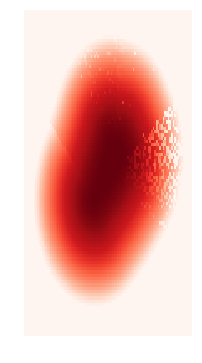

In [63]:
shapeSence.showHeatMap()